In [1]:
import asrtoolkit
from asrtoolkit import wer, cer
import cv2
import io
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import numpy as np
from PIL import Image
import pytesseract
import sys
#skimage causing issues with io standard library, hence import as
from skimage import io as ioski
from skimage.color import rgb2gray
from skimage.transform import rotate, resize
import os
import re
from google.cloud import vision
#from google.cloud.vision_v1 import types
#from google.cloud.vision_v1.types import Image
from deskew import determine_skew
#from dotenv import load_dotenv, find_dotenv
#load_dotenv()
from google.cloud import storage

In [2]:
IMG_DIR = 'C:/Users/Gauri/3) PROJECTS/Image to Text'

In [3]:
sample_img = IMG_DIR +'/sample4.jpg'

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1600x976 at 0x282CAA3A020>


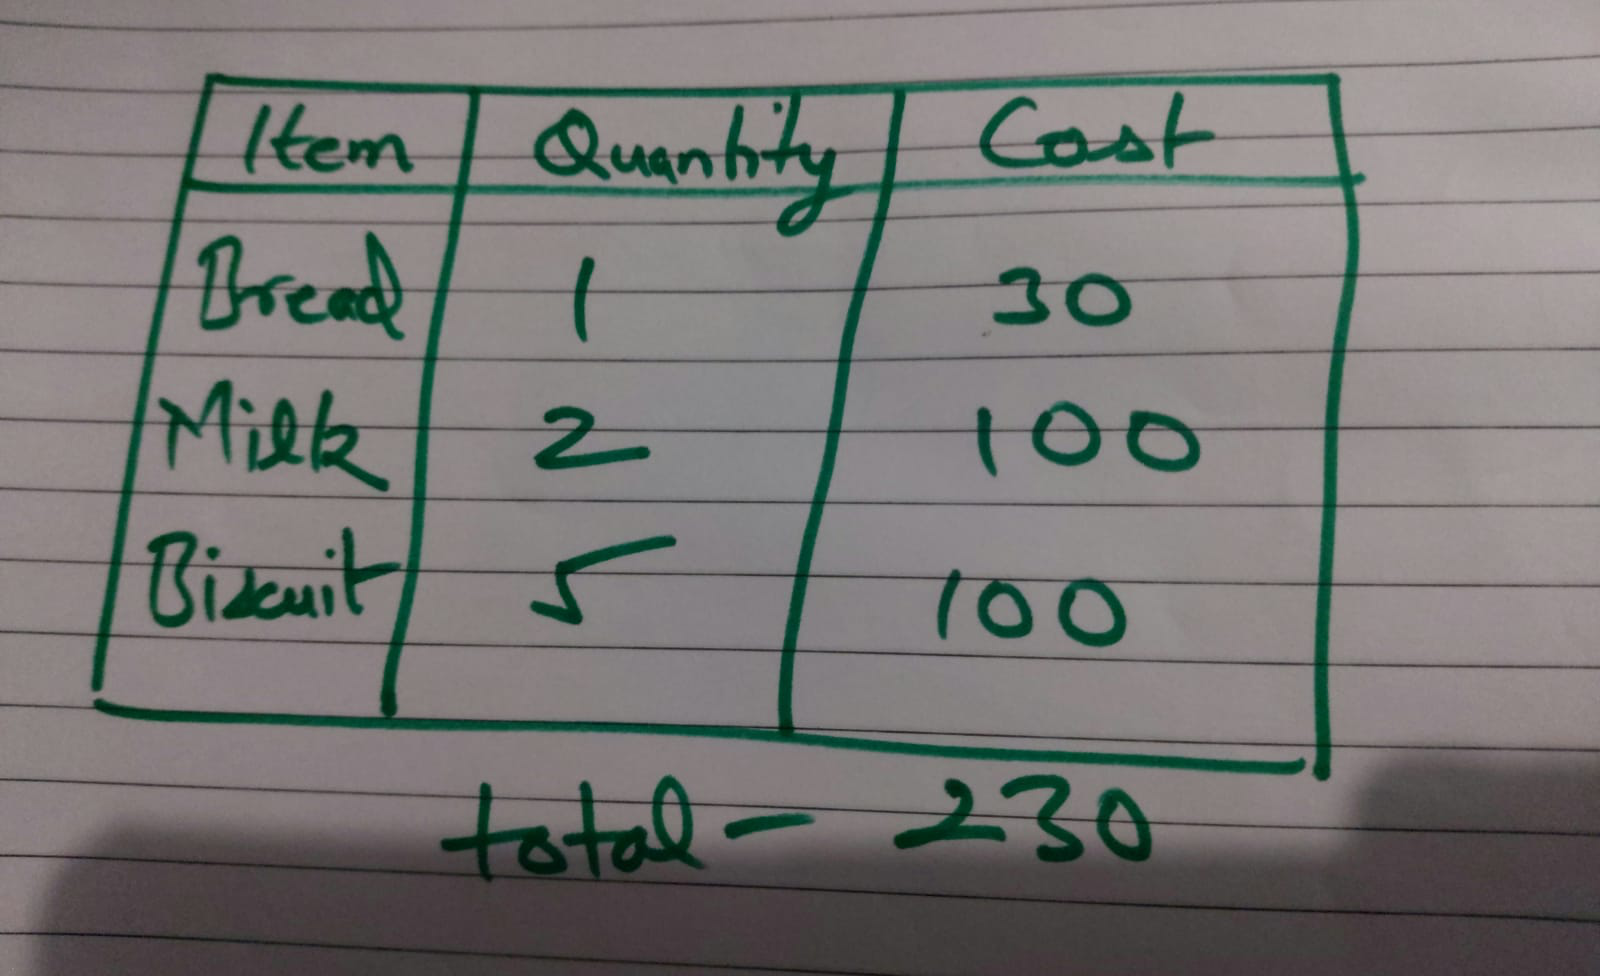

In [4]:
outputimage = Image.open(sample_img)
print(outputimage)
outputimage

In [5]:
image = ioski.imread(sample_img)
grayscale = rgb2gray(image)
angle = determine_skew(grayscale)
print(angle)
rotated = rotate(image, angle, resize=True) * 255
print(type(rotated))
ioski.imsave("output_deskewed.png", rotated.astype(np.uint8))

2.0000000000000027
<class 'numpy.ndarray'>


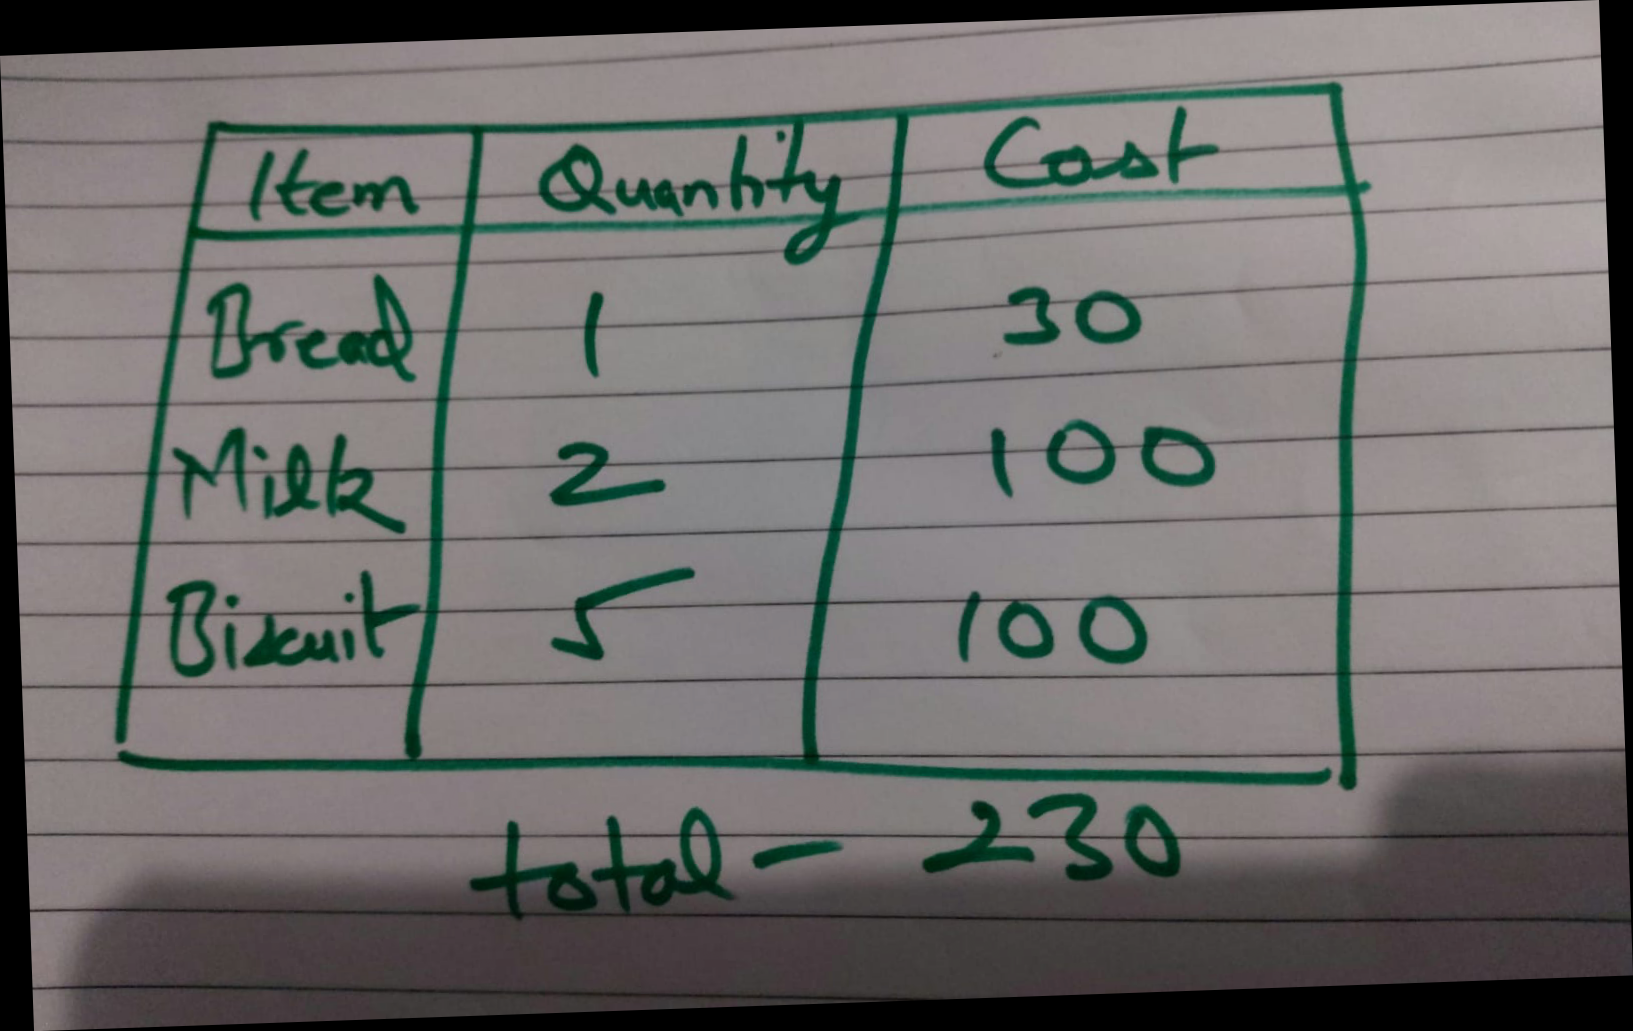

In [6]:
Image.open("output_deskewed.png")

In [7]:
def pre_process_image(image):
    """This function will pre-process a image with: cv2 & deskew
    so it can be process by tesseract"""
    img = cv2.imread(image)
    img = cv2.resize(img, None, fx=.3, fy=.3) #resize using percentage
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #change color format from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #format image to gray scale
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 11) #to remove background
    return img

In [8]:
def img_process(image):
    """This function will deskew"""
    cv2output = io.imread(image)
    angle = determine_skew(cv2output)
    print("angle rotation of image",angle)
    rotated = rotate(cv2output, angle, resize=True) * 255
    return rotated

In [9]:
#use function pre_process_image to output processed image to a saved file.
processed_img = pre_process_image("output_deskewed.png")
cv2.imwrite("output_processed.png",processed_img)
processed_img = pre_process_image(sample_img)
cv2.imwrite("output_no_deskewing.png",processed_img)

True

In [10]:
ground_truth = "The writer and his grandmother were very good friends. gramma used to drop him to school as it was side by side to the church. the priest used to teach the children the alphabets and when they were done they would leave and go home together."

In [11]:
#pytesseract no preprocessing
hypothesis0 = pytesseract.image_to_string(sample_img)
print("CER, WER, Rate :",cer(ground_truth, hypothesis0),wer(ground_truth, hypothesis0),fuzz.ratio(ground_truth, hypothesis0))
print(hypothesis0)

CER, WER, Rate : 100.0 100.0 9
 

 

 

 

 

 

 

    
 



In [12]:
#pytesseract out of the box with deskew & rgb2gray
hypothesis1 = pytesseract.image_to_string("output_deskewed.png")
print("CER, WER, Rate :",cer(ground_truth, hypothesis1),wer(ground_truth, hypothesis1),fuzz.ratio(ground_truth, hypothesis1))
print(hypothesis1)

CER, WER, Rate : 97.47899159663865 100.0 8
 

 

 

 

 

rs i
r

 



In [13]:
#pytesseract out of the box with preprocessing (no deskewing)
hypothesis2 = pytesseract.image_to_string("output_no_deskewing.png")
print("CER, WER, Rate :",cer(ground_truth, hypothesis2),wer(ground_truth, hypothesis2),fuzz.ratio(ground_truth, hypothesis2))
print(hypothesis2)

CER, WER, Rate : 100.0 100.0 10
 

 

 

 

 

 

 

 

 

 

 

 

 

 



In [14]:
#pytesseract out of the box with preprocessing w/ deskewing
hypothesis3 = pytesseract.image_to_string("output_processed.png")
print("CER, WER, Rate :",cer(ground_truth, hypothesis3),wer(ground_truth, hypothesis3),fuzz.ratio(ground_truth, hypothesis3))
print(hypothesis3)

CER, WER, Rate : 100.0 100.0 10
 

 

 

 

 

 

 

 

 

 

 

 

 

 



In [15]:
#pytesseract with ssq.traineddata, preprocessing
hypothesis4 = pytesseract.image_to_string("output_processed.png", lang="ssq")
print("CER, WER, Rate :",cer(ground_truth, hypothesis4),wer(ground_truth, hypothesis4),fuzz.ratio(ground_truth, hypothesis4))
print(hypothesis4)

CER, WER, Rate : 100.0 100.0 10
 

 

 

 

 

 

 

 

 

 

 

 

 

 



In [16]:
client = vision.ImageAnnotatorClient()

In [17]:
#pass the image with text(handwritten) to google vision output string
with io.open("output_processed.png",'rb') as image_file:
    content = image_file.read()

image_v = vision.Image(content=content)
response = client.document_text_detection(image=image_v)
docText = response.full_text_annotation.text
hypothesis5 = docText

print("CER, WER, Rate :",cer(ground_truth, hypothesis5),wer(ground_truth, hypothesis5),fuzz.ratio(ground_truth, hypothesis5))
print(hypothesis5)

CER, WER, Rate : 83.61344537815125 100.0 16
Kom | Quantity | Cast
Break
1
Milk
| Bizzmily
J
FA
too
SGD BEDOK


In [18]:
#pass the image with text(handwritten) to google vision output string
with io.open("output_deskewed.png",'rb') as image_file:
    content = image_file.read()

image_v = vision.Image(content=content)
response = client.document_text_detection(image=image_v)
docText = response.full_text_annotation.text
hypothesis6 = docText
print("CER, WER, Rate :",cer(ground_truth, hypothesis6),wer(ground_truth, hypothesis6),fuzz.ratio(ground_truth, hypothesis6))
print(hypothesis6)

CER, WER, Rate : 72.6890756302521 97.82608695652173 18
Item Quantity
Bread
t
Milk
2
Biscuit S
Cast
30
100
100
total-230
